In [2]:
#Imports
import sys,os
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel
from quspin.operators import hamiltonian,quantum_operator
from quspin.basis import spin_basis_1d
from numpy.random import uniform,seed
from joblib import delayed,Parallel
from itertools import combinations
from functools import partial
import numpy as np
import gc
import pickle
from time import time
from quspin.tools.measurements import diag_ensemble
from quspin.tools.evolution import ED_state_vs_time
import matplotlib.pyplot as plt
timestamp = time()

The general $\mathcal{U}$ matrix is given by $\begin{bmatrix}
\mathbf{U} & \mathbf{V*} \\
\mathbf{V} & \mathbf{U*}
\end{bmatrix}
$ representing the eigen values of the $2\times2$ matrix. The correlation and anomolous correlation functions are given by

$\mathbf{G}= \mathbf{U}\mathbf{U}^\dagger$ and $\mathbf{F}= \mathbf{U}\mathbf{V}^\dagger$

In [35]:
#The general $\mathcal{G}$ matrix is 
def Gi(psi):
    #General G matrix (In which G and F live)
    return psi @ psi.T.conj() 


def H_bdg(h, L, J):
    #Generating Hamiltonian
    A = np.zeros((L, L))
    B = np.zeros((L, L))

    for j in range(L):
        A[j, j] = 2 * h
    for j in range(L - 1):
        A[j, j + 1] = A[j + 1, j] = -J
        B[j, j + 1] = -J
        B[j + 1, j] = J

   # Antiperiodic boundary condition (ABC) introduces a minus sign

    A[0, L - 1] = A[L - 1, 0] = J
    B[L - 1, 0] = J
    B[0, L - 1] = -J

    #Periodic 
    # A[0, L - 1] = A[L - 1, 0] = -J
    # B[L - 1, 0] = -J
    # B[0, L - 1] = J

    return 1/2*np.block([[A, B], [-B, -A]])


(0.0, 1.0)

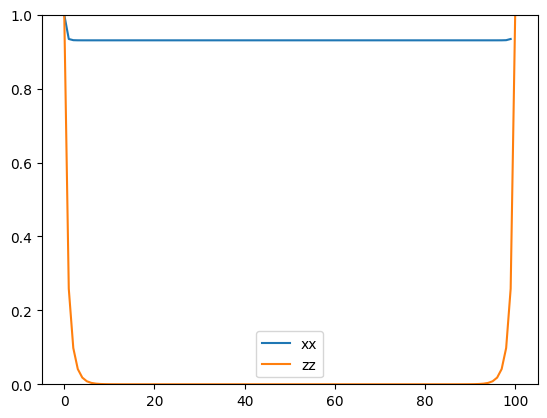

In [73]:
###Calculating Sigma_zz, sigma_xx ####
#Params
L = 100
J =-1
h = 1/2


E1, U1_full = np.linalg.eigh(H_bdg(h, L,J))
U1 = U1_full[:, :L]         # only negative-energy modes
G = Gi(U1)                  # full 2L × 2L correlation matrix
G1 = G[:L, :L]              # ⟨c† c⟩
F1 = G[:L, L:]              # ⟨c c⟩
M_t = np.eye(L)-2*(G1+F1)


n = np.arange(L+1)
zz = []
for ni in n:
    M = np.zeros((ni, ni), dtype=np.complex128)
    for j in range(ni):
        for jp in range(ni):
            s = int(j == jp)
            s += -2 * G1[j, jp]
            s += -2 * F1[j, jp]
            M[j, jp] = s
    zz.append(np.linalg.det(M))
j1 = 0
xx = []
for j2 in range(L):
    n = j2 - j1
    C = np.zeros((n, n), dtype=np.complex128)
    for x in range(n):
        for y in range(n):
            C[x, y] = M_t[j1 + x, j1 + 1 + y]
    xx.append(np.linalg.det(C))


plt.plot(xx,label = "xx")
plt.plot(zz,label = "zz")
#plt.plot(yy,label="yy")

plt.legend()
plt.ylim(0,1)


Adiabatic Tests:


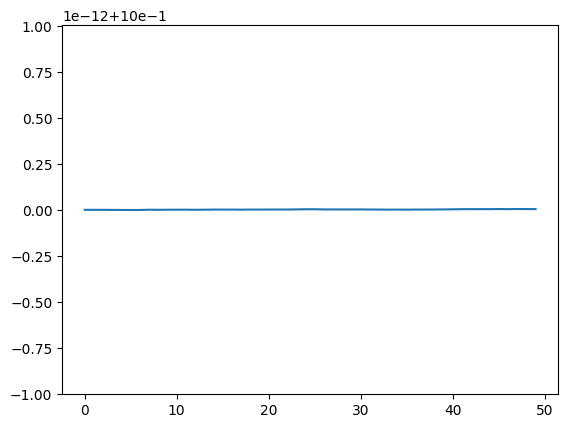

In [77]:
def h_t(t, tau, h0, hf):
    return h0 + (hf - h0) * (t / tau)
J =-1
L = 50
tau = 100
N_steps = 100
times,dt= np.linspace(0,tau,N_steps,retstep=True)
h0 = 0
hf = 1
H_bdg_t = [H_bdg(h_t(ti, tau, h0,hf), L,J) for ti in times]
E1, U1_full = np.linalg.eigh(H_bdg_t[0])
U1 = U1_full[:, :L]         # only negative-energy modes
G = Gi(U1)                  # full 2L × 2L correlation matrix
G1 = G[:L, :L]              # ⟨c† c⟩
F1 = G[:L, L:]              # ⟨c c⟩
M_t = np.eye(L)-2*(G1+F1)
j1 = 0
xx = []
for j2 in range(L):
    n = j2 - j1
    C = np.zeros((n, n), dtype=np.complex128)
    for x in range(n):
        for y in range(n):
            C[x, y] = M_t[j1 + x, j1 + 1 + y]
    xx.append(np.linalg.det(C))


plt.plot(xx,label = "xx")

In [78]:
pt = np.asarray(U1_full, dtype=np.complex128)
T = H_bdg_t
dat1 = [pt.copy()]
U = pt[:, :L]  # initial negative-energy modes
U = np.asarray(U, dtype=np.complex128)
xxx=[]
for t in times:
        H = H_bdg(h_t(t, tau, h0, hf), L,J)
        # U += -2j * H @ U * dt
        I = np.eye(2*L)
        A = I + 0.5j * dt * H
        B = I - 0.5j * dt * H
        U = np.linalg.solve(A, B @ U)
        G = Gi(U)                  # full 2L × 2L correlation matrix
        G1 = G[:L, :L]              # ⟨c† c⟩
        F1 = G[:L, L:]              # ⟨c c⟩
        M_t = np.eye(L)-2*(G1+F1)
        j1 = 0
        xx = []
        for j2 in range(L):
                n = j2 - j1
                C = np.zeros((n, n), dtype=np.complex128)
                for x in range(n):
                        for y in range(n):
                                C[x, y] = M_t[j1 + x, (j1 + 1 + y)]
                xx.append(np.linalg.det(C))
        xxx.append(xx)

        # Optional stabilization:
        # U, _ = np.linalg.qr(U)


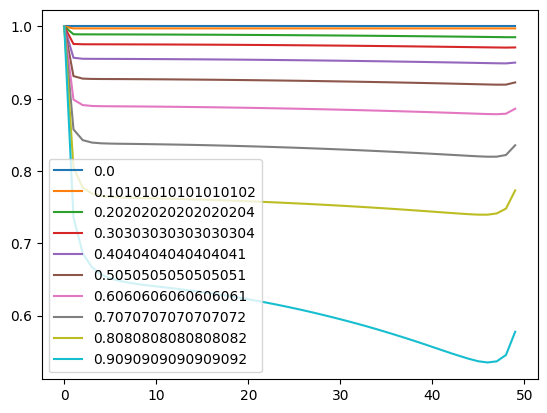

In [79]:
for i in range(0,len(xxx),10):
    plt.plot(xxx[i],label = h_t(times[i],tau,h0,hf))
plt.legend()